In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os
import fiona
from tqdm import tqdm

In [2]:
import logging

import atlite

logging.basicConfig(level=logging.INFO)

import io
import pathlib

import numpy as np
import requests
import xarray
from shapely.geometry import Polygon
from rasterio.features import rasterize
from shapely.geometry import mapping
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.enums import Resampling
from rasterio.crs import CRS
from affine import Affine

from rasterio.features import rasterize
from rasterio.transform import from_bounds
from shapely.geometry import box
from zipfile import ZipFile
import numpy as np

from rasterio.plot import show
from rasterio.mask import mask

from atlite.gis import ExclusionContainer, shape_availability

In [3]:
aggregated_regions = [
    "AT", "BE", "BG", "CH", "CZ", "DE",
    "DK", "EE", "ES", "FI", "FR", "UK",
    "GR", "HR", "HU", "IE", "IT", "LT",
    "LU", "LV", "NL", "NO", "PL", "PT", 
    "RO", "SE", "SI", "SK",
]

In [4]:
europe = (
    gpd
    .read_file('/home/oskar/shared_input/geodata/onshore/shapes/NUTS_RG_10M_2021_4326.geojson')
    .query("NUTS_ID == @aggregated_regions")
    .set_index(["NUTS_ID"])
    .loc[:,['geometry']]
)

In [5]:
# The square outer boundaries of Europe to consider, because we have downloaded ERA5 for this extent:
rectx1 = -12
rectx2 = 44
recty1 = 33
recty2 = 72

In [6]:
polygon = Polygon(
    [
        (rectx1, recty1),
        (rectx1, recty2),
        (rectx2, recty2),
        (rectx2, recty1),
        (rectx1, recty1),
    ]
)
europe = gpd.clip(europe, polygon)

In [7]:
def plot_eligible_area(ax, tiff_path, europe, title):
    excluder_wind_onshore = ExclusionContainer()

    # Ensuring the correct CRS for full_europe
    full_europe = (
        europe
        .assign(col='a')
        .dissolve(by='col')
        .geometry
    )

    # Open the TIFF file and ensure CRS matches
    with rasterio.open(tiff_path) as src:
        if full_europe.crs != src.crs:
            full_europe = full_europe.to_crs(src.crs)

    # Bufffer geometry ensuring CRS consistency
    full_europe = full_europe.to_crs(excluder_wind_onshore.crs)

    # Example mask and transformation logic
    excluder_wind_onshore.add_raster(tiff_path)
    masked, transform = shape_availability(full_europe, excluder_wind_onshore)
    eligible_share = (masked.sum() * excluder_wind_onshore.res**2 / full_europe.geometry.item().area)
    
    # Plot the eligible area in a subplot
    show(masked, transform=transform, cmap='Greens', ax=ax)
    full_europe.plot(ax=ax, edgecolor='k', color='None')
    europe.to_crs(excluder_wind_onshore.crs).boundary.plot(ax=ax, edgecolor='grey', linewidth=0.2)
    ax.set_title(f'{title} Eligible area (green) {eligible_share * 100:2.2f}%')

In [8]:
slope = '/home/oskar/shared_input/geodata/onshore/euro_slope_40degs.tif'
elev = '/home/oskar/shared_input/geodata/onshore/2000m.shp.zip'
powerlines = '/home/oskar/shared_input/geodata/onshore/wimby/powerlines.gpkg'
rail = '/home/oskar/shared_input/geodata/onshore/wimby/rail.gpkg'
airports = '/home/oskar/shared_input/geodata/onshore/wimby/airport.gpkg'
glaciers = '/home/oskar/shared_input/geodata/onshore/wimby/glacier.gpkg'
roads_motorways = '/home/oskar/shared_input/geodata/onshore/wimby/roads_motorways.gpkg'
roads_primary = '/home/oskar/shared_input/geodata/onshore/wimby/roads_primary.gpkg'
military = '/home/oskar/shared_input/geodata/onshore/wimby/military.gpkg'
radar = '/home/oskar/shared_input/geodata/onshore/wimby/radar.gpkg'


In [9]:
# Define a dictionary with each key as GeoPackage file and value as list of layers with their buffer distances
buffer_dict = {
    'radar.gpkg': [
        {'layer_name': 'radar', 'buffer_distance': 6000},
    ],
    'military.gpkg': [
        {'layer_name': 'military', 'buffer_distance': 5500},
    ],
    'rail.gpkg': [
        {'layer_name': 'rail', 'buffer_distance': 190},
        {'layer_name': 'narrow', 'buffer_distance': 190}
    ],
    'airport.gpkg': [
        {'layer_name': 'airports', 'buffer_distance': 6000}
    ],
    'powerlines.gpkg': [
        {'layer_name': 'powerlines', 'buffer_distance': 165}
    ],
    'glacier.gpkg': [
        {'layer_name': 'glacier', 'buffer_distance': 0}
    ],
    'roads_motorways.gpkg': [
        {'layer_name': 'motorway', 'buffer_distance': 165},
        {'layer_name': 'motorway_link', 'buffer_distance': 165},
        {'layer_name': 'trunk', 'buffer_distance': 165}
    ],
    'roads_primary.gpkg': [
        {'layer_name': 'primary', 'buffer_distance': 165}
    ]
}


In [10]:
# Specify the path to your GeoPackage file
gpkg_file = '/home/oskar/shared_input/geodata/onshore/wimby/radar.gpkg'

# Open the GeoPackage and list its layers
with fiona.Env():
    # Get the list of layers
    layers = fiona.listlayers(gpkg_file)
    
    # Print out the list of layers
    print("Layers available in the GeoPackage:")
    for layer in layers:
        print(layer)

Layers available in the GeoPackage:
radar


In [11]:
minx = -1335833.8895192828
maxx = 4898057.594904037
miny = 3895303.9633938945
maxy = 11753184.615338452

In [12]:
def buffer_and_rasterize_layer(gpkg_file, layer_name, buffer_distance, output_tiff):
    os.makedirs(os.path.dirname(output_tiff), exist_ok=True)
    
    # Read the layer from the GeoPackage
    gdf = gpd.read_file(gpkg_file, layer=layer_name)

    # Identify geometry type and buffer lines. 
    # The buffer distance for point data can be adjusted as needed.
    if gdf.geom_type.isin(['LineString', 'MultiLineString','Point']).any():
        # Buffer lines
        resolution = 100
        gdf['geometry'] = gdf['geometry'].buffer(buffer_distance)
    elif gdf.geom_type.isin(['Polygon', 'MultiPolygon']).any():
        resolution = 100
        # Potentially simplify polygons or use them directly if necessary
        gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.001)
        gdf['geometry'] = gdf['geometry'].buffer(buffer_distance)
    else:
        raise ValueError("No suitable geometry types found for processing")

    # Calculate the boundary of the output raster
    #minx, miny, maxx, maxy = gdf.total_bounds
    minx = -1335833.8895192828
    maxx = 4898057.594904037
    miny = 3895303.9633938945
    maxy = 11753184.615338452
    #resolution = 100  # Adjust resolution as needed
    width = int((maxx - minx) / resolution)
    height = int((maxy - miny) / resolution)
    transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, width, height)

    # Rasterize the buffered geometries
    rasterized = rasterize(
        [(geom, 1) for geom in gdf.geometry if geom is not None],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='uint8'
    )

    # Write the raster to file with compression
    with rasterio.open(
        output_tiff, 'w',
        driver='GTiff',
        height=rasterized.shape[0],
        width=rasterized.shape[1],
        count=1,
        dtype='uint8',
        crs='EPSG:3857',
        transform=transform,
        compress='lzw'
    ) as dst:
        dst.write(rasterized, 1)

    print(f'Rasterized buffer saved to {output_tiff}')

In [13]:
gpkg_files = [
    powerlines,
    rail,
    airports,
    glaciers,
    roads_motorways,
    roads_primary,
    military,
    radar,
]

# Loop over each GeoPackage file and its respective layers
for gpkg_file in tqdm(gpkg_files):
    base_name = gpkg_file.split('/')[-1]  # Extract filename
    if base_name in buffer_dict:
        for layer_info in buffer_dict[base_name]:
            layer_name = layer_info['layer_name']
            buffer_distance = layer_info['buffer_distance']
            output_tiff = f'/home/oskar/shared_input/geodata/onshore/wimby/processed/{base_name.replace(".gpkg", "")}_{layer_name}_buffered.tif'
            buffer_and_rasterize_layer(gpkg_file, layer_name, buffer_distance, output_tiff)


 12%|█████▋                                       | 1/8 [01:14<08:39, 74.27s/it]

Rasterized buffer saved to /home/oskar/shared_input/geodata/onshore/wimby/processed/powerlines_powerlines_buffered.tif
Rasterized buffer saved to /home/oskar/shared_input/geodata/onshore/wimby/processed/rail_rail_buffered.tif


 25%|███████████                                 | 2/8 [05:06<16:42, 167.00s/it]

Rasterized buffer saved to /home/oskar/shared_input/geodata/onshore/wimby/processed/rail_narrow_buffered.tif


 38%|████████████████▌                           | 3/8 [05:29<08:27, 101.44s/it]

Rasterized buffer saved to /home/oskar/shared_input/geodata/onshore/wimby/processed/airport_airports_buffered.tif


 50%|██████████████████████▌                      | 4/8 [05:56<04:48, 72.15s/it]

Rasterized buffer saved to /home/oskar/shared_input/geodata/onshore/wimby/processed/glacier_glacier_buffered.tif
Rasterized buffer saved to /home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_motorway_buffered.tif
Rasterized buffer saved to /home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_motorway_link_buffered.tif


 62%|███████████████████████████▌                | 5/8 [09:55<06:36, 132.30s/it]

Rasterized buffer saved to /home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_trunk_buffered.tif


 75%|█████████████████████████████████           | 6/8 [15:06<06:25, 192.94s/it]

Rasterized buffer saved to /home/oskar/shared_input/geodata/onshore/wimby/processed/roads_primary_primary_buffered.tif


 88%|██████████████████████████████████████▌     | 7/8 [15:34<02:19, 139.06s/it]

Rasterized buffer saved to /home/oskar/shared_input/geodata/onshore/wimby/processed/military_military_buffered.tif


100%|████████████████████████████████████████████| 8/8 [15:54<00:00, 119.28s/it]

Rasterized buffer saved to /home/oskar/shared_input/geodata/onshore/wimby/processed/radar_radar_buffered.tif


In [14]:
convert_slope = 'No'

In [15]:
if convert_slope == 'Yes':
    # Open the existing raster
    with rasterio.open(slope) as src:
        # Calculate transform of the new intended output dimensions
        new_transform = Affine.translation(minx, maxy) * Affine.scale(
            (maxx - minx) / src.width,
            (miny - maxy) / src.height)

        # Calculate new width and height
        new_width = int((maxx - minx) / new_transform.a)
        new_height = int((maxy - miny) / -new_transform.e)

        kwargs = src.meta.copy()
        kwargs.update({
            'crs': CRS.from_epsg(3857),
            'transform': new_transform,
            'width': new_width,
            'height': new_height,
            'compress': 'lzw'  # Add LZW compression
        })

        with rasterio.open('/home/oskar/shared_input/geodata/onshore/wimby/processed/euro_slope_40degs.tif', 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=new_transform,
                    dst_crs=CRS.from_epsg(3857),
                    resampling=Resampling.nearest)

In [16]:
convert_shapefiles = 'No'

In [17]:
shapefile_paths = [
    '/home/oskar/shared_input/geodata/onshore/15degrees.shp.zip',
    '/home/oskar/shared_input/geodata/onshore/2000m.shp.zip'
]
# NOTE THAT IF NEW FILES ARE ADDED, IT NEEDS TO BE VERIFIED THAT THE RELEVANT DATA IS WHERE GRIDCODE = 2

if convert_shapefiles == 'Yes':
    for file in tqdm(shapefile_paths):
        # Define your spatial extent and resolution
        resolution = 100  # Set appropriate resolution (100m as an example)
        
        # Unzip the shapefile
        shapefile_zip = file
        with ZipFile(shapefile_zip, 'r') as z:
            z.extractall(path='temp_directory')
        
        # Load the shapefile
        shapefile_path = [name for name in z.namelist() if name.endswith('.shp')][0]
        shapefile_path = os.path.join('temp_directory', shapefile_path)
        gdf = gpd.read_file(shapefile_path)
        gdf = gdf.query("gridcode == 2")
        
        # Transform the GeoDataFrame to your desired CRS, if necessary
        gdf = gdf.to_crs(epsg=3857)
        
        
        # Generate a mask for the rasterization
        transform = from_bounds(minx, miny, maxx, maxy, int((maxx - minx) / resolution), int((maxy - miny) / resolution))
        
        # Rasterize the GeoDataFrame
        out_shape = (int((maxy - miny) / resolution), int((maxx - minx) / resolution))
        rasterized = rasterize(
            [(geom, 1) for geom in gdf.geometry], 
            out_shape=out_shape,
            transform=transform,
            fill=0,
            all_touched=True,
            dtype='uint8'
        )
        
        # Define the raster metadata
        raster_meta = {
            'driver': 'GTiff',
            'height': out_shape[0],
            'width': out_shape[1],
            'count': 1,
            'dtype': 'uint8',
            'crs': 'EPSG:3857',
            'transform': transform,
            'compress': 'lzw'  # Apply compression
        }
        
        # Write the raster to a file
        output_raster = f'/home/oskar/shared_input/geodata/onshore/wimby/processed/{file.split('/')[-1].split('.')[-3]}.tif'
        with rasterio.open(output_raster, 'w', **raster_meta) as dst:
            dst.write(rasterized, 1)
        
        # Clean up temporary directory if necessary
        import shutil
        shutil.rmtree('temp_directory')
        
        print(f"Raster saved to {output_raster}")


In [18]:
tiff_paths = [
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/airport_airports_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/15degrees.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/powerlines_powerlines_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/rail_narrow_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/glacier_glacier_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_motorway_link_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/military_military_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/radar_radar_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/2000m.tif'
    #'/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_primary_primary_buffered.tif',
]

In [19]:
name_dict = {
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/airport_airports_buffered.tif' : 'Airports 5km buffer',
    '/home/oskar/shared_input/geodata/onshore/euro_slope_40degs.tif' : 'Slope 36°',
    '/home/oskar/shared_input/geodata/onshore/wimby/15degrees.tif' : 'Slope 15°',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/powerlines_powerlines_buffered.tif' : 'Powerlines',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/rail_narrow_buffered.tif' : 'Rail - Narrow',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/glacier_glacier_buffered.tif' : 'Glaciers',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_motorway_link_buffered.tif' : 'Roads - Motorways',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_primary_primary_buffered.tif': 'Roads - Primary',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/military_military_buffered.tif': 'Military 5.5km buffer',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/radar_radar_buffered.tif': 'Radars 6km buffer',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/2000m.tif': 'Elevation (2000m)',
}

In [20]:
name_dict

{'/home/oskar/shared_input/geodata/onshore/wimby/processed/airport_airports_buffered.tif': 'Airports 5km buffer',
 '/home/oskar/shared_input/geodata/onshore/euro_slope_40degs.tif': 'Slope 36°',
 '/home/oskar/shared_input/geodata/onshore/wimby/15degrees.tif': 'Slope 15°',
 '/home/oskar/shared_input/geodata/onshore/wimby/processed/powerlines_powerlines_buffered.tif': 'Powerlines',
 '/home/oskar/shared_input/geodata/onshore/wimby/processed/rail_narrow_buffered.tif': 'Rail - Narrow',
 '/home/oskar/shared_input/geodata/onshore/wimby/processed/glacier_glacier_buffered.tif': 'Glaciers',
 '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_motorway_link_buffered.tif': 'Roads - Motorways',
 '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_primary_primary_buffered.tif': 'Roads - Primary',
 '/home/oskar/shared_input/geodata/onshore/wimby/processed/military_military_buffered.tif': 'Military 5.5km buffer',
 '/home/oskar/shared_input/geodata/onshore/wimby/process

In [21]:
import math

7it [14:55, 143.86s/it]INFO:rasterio._env:GDAL signalled an error: err_no=4, msg='/home/oskar/shared_input/geodata/onshore/wimby/processed/radar_radar_buffered.tif/home/oskar/shared_input/geodata/onshore/wimby/processed/2000m.tif: Not a directory'
7it [14:55, 127.97s/it]


RasterioIOError: /home/oskar/shared_input/geodata/onshore/wimby/processed/radar_radar_buffered.tif/home/oskar/shared_input/geodata/onshore/wimby/processed/2000m.tif: Not a directory

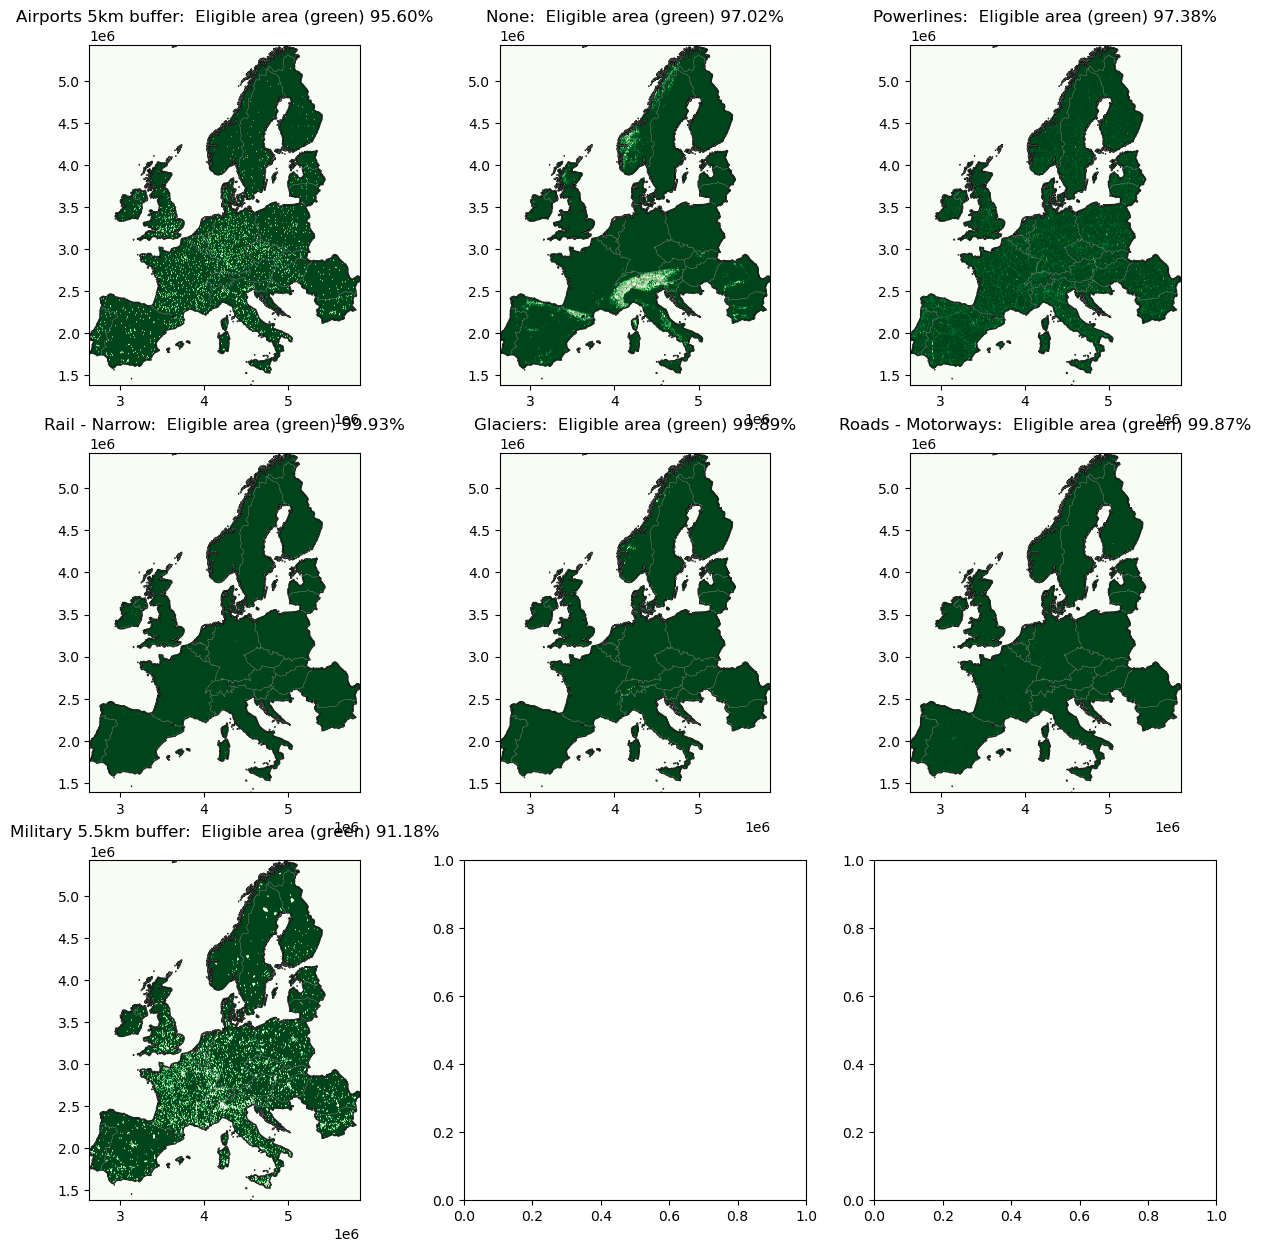

In [22]:
# Create subplots - one for each file
n_files = len(tiff_paths)
columns = 3
rows = math.ceil(n_files/columns)

fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 5 * rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each file on the corresponding subplot
for ax, tiff_path in tqdm(zip(axes, tiff_paths)):
    plot_eligible_area(ax, tiff_path, europe, f'{name_dict.get(tiff_path)}: ')

# Turn off unused subplots
for ax in axes[n_files:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()
